In [1]:
# UPORABNO:
# Povezava: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [159]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [160]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [161]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki

Odjem ACT  Temperatura ACT  Temperatura FC  Sevanje ACT  \
DateTimeStartUTC                                                               
2021-10-31 23:00:00    9508.67             3.60           5.300          0.0   
2021-10-31 23:15:00    9168.37             3.60           5.300          0.0   
2021-10-31 23:30:00    8860.11             3.60           5.300          0.0   
2021-10-31 23:45:00    8510.97             3.60           5.300          0.0   
2021-11-01 00:00:00    8332.21             3.45           5.300          0.0   
...                        ...              ...             ...          ...   
2024-02-29 21:45:00   12005.50             6.80           7.475          0.0   
2024-02-29 22:00:00   11336.40             6.65           7.300          0.0   
2024-02-29 22:15:00   10796.70             6.50           7.300          0.0   
2024-02-29 22:30:00   10218.60             6.50           7.300          0.0   
2024-02-29 22:45:00    9887.46             6.50           7.300          0.0   

                     Sevanje FC  Year  Month         Day  
DateTimeStartUTC                                          
2021-10-31 23:00:00         0.0  2021     10  2021-10-31  
2021-10-31 23:15:00         0.0  2021     10  2021-10-31  
2021-10-31 23:30:00         0.0  2021     10  2021-10-31  
2021-10-31 23:45:00         0.0  2021     10  2021-10-31  
2021-11-01 00:00:00         0.0  2021     11  2021-11-01  
...                         ...   ...    ...         ...  
2024-02-29 21:45:00         0.0  2024      2  2024-02-29  
2024-02-29 22:00:00         0.0  2024      2  2024-02-29  
2024-02-29 22:15:00         0.0  2024      2  2024-02-29  
2024-02-29 22:30:00         0.0  2024      2  2024-02-29  
2024-02-29 22:45:00         0.0  2024      2  2024-02-29  

[81696 rows x 8 columns]

In [162]:
## Številki opis podatkov:
pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))

Min      Max     Povprečje   Mediana           sd
0  Odjem  3629.32  28736.8  12240.501427  11708.45  4167.961058

In [163]:
## Vizualizacija
sns.set(rc={'figure.figsize':(20, 5)}) # sets the default figure size

<AxesSubplot: xlabel='DateTimeStartUTC'>

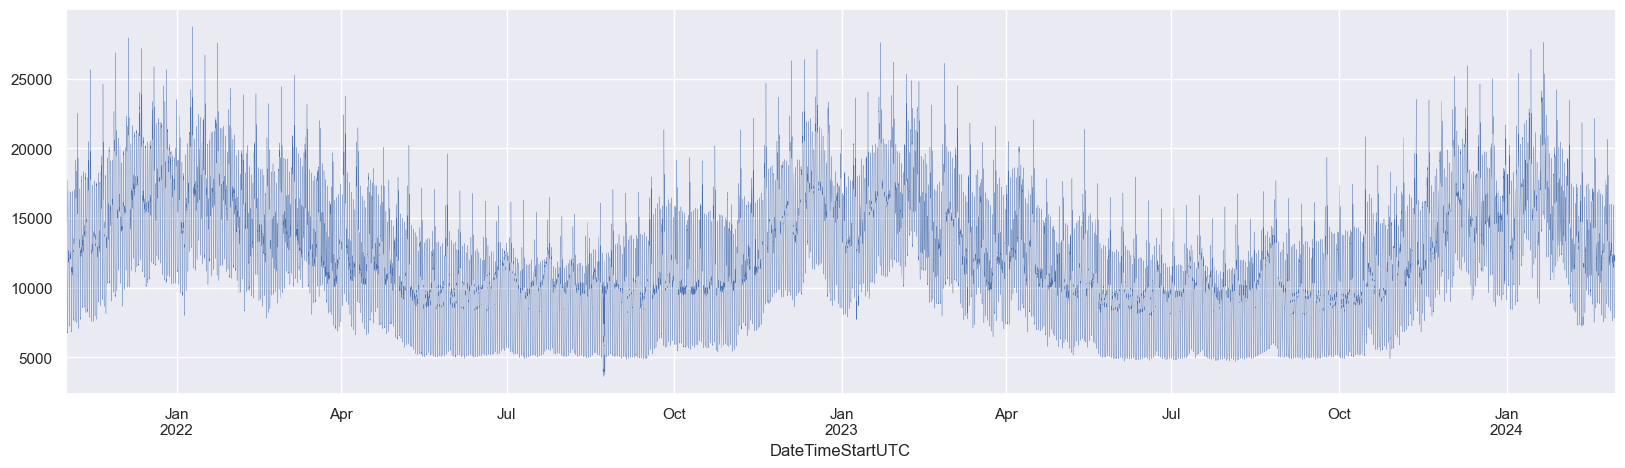

In [6]:
podatki['Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

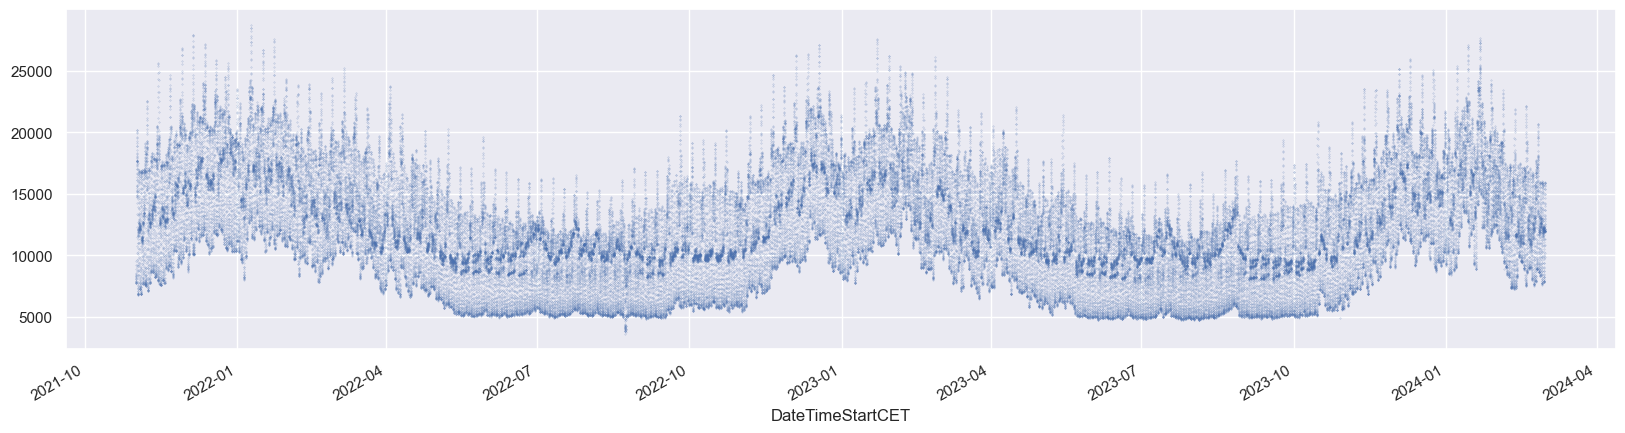

In [49]:
podatki['Odjem ACT'].plot(marker='.', alpha=0.5, linestyle='None', ms=0.5)
# iz tega grafa je malo boljše lažje razbrat stvari

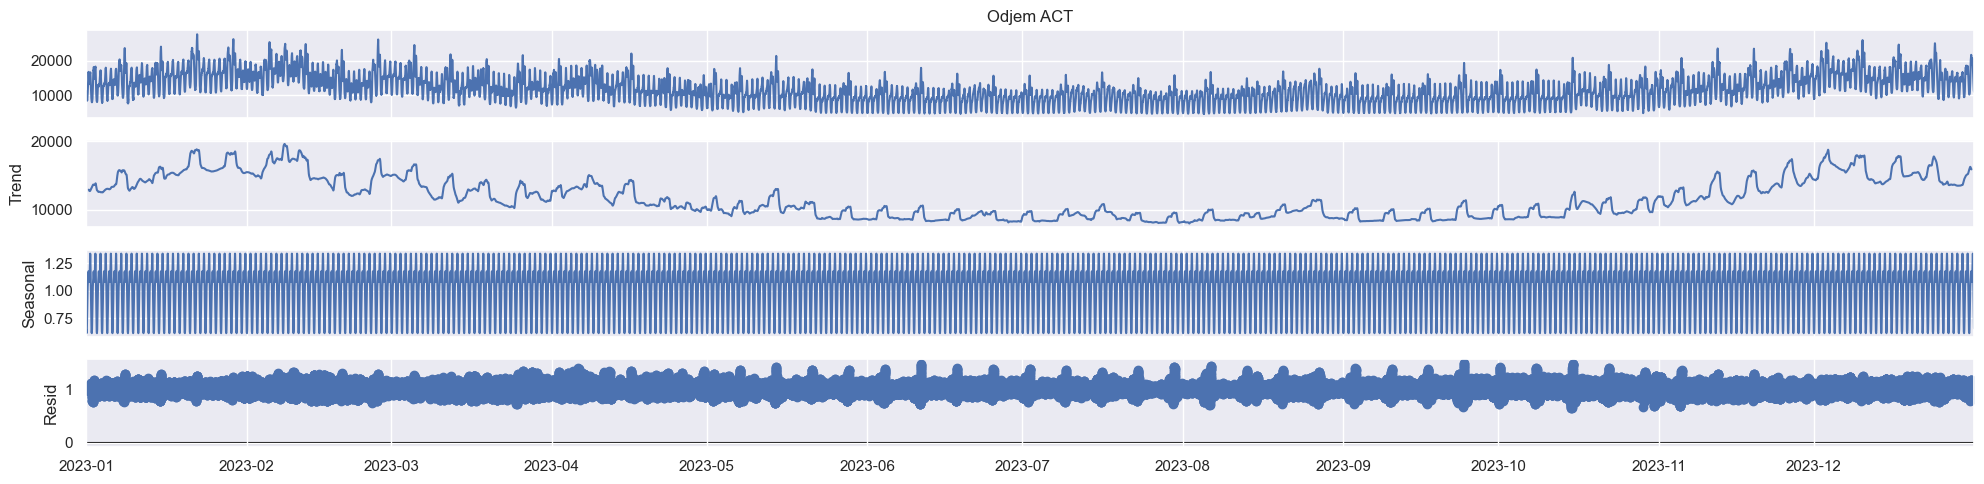

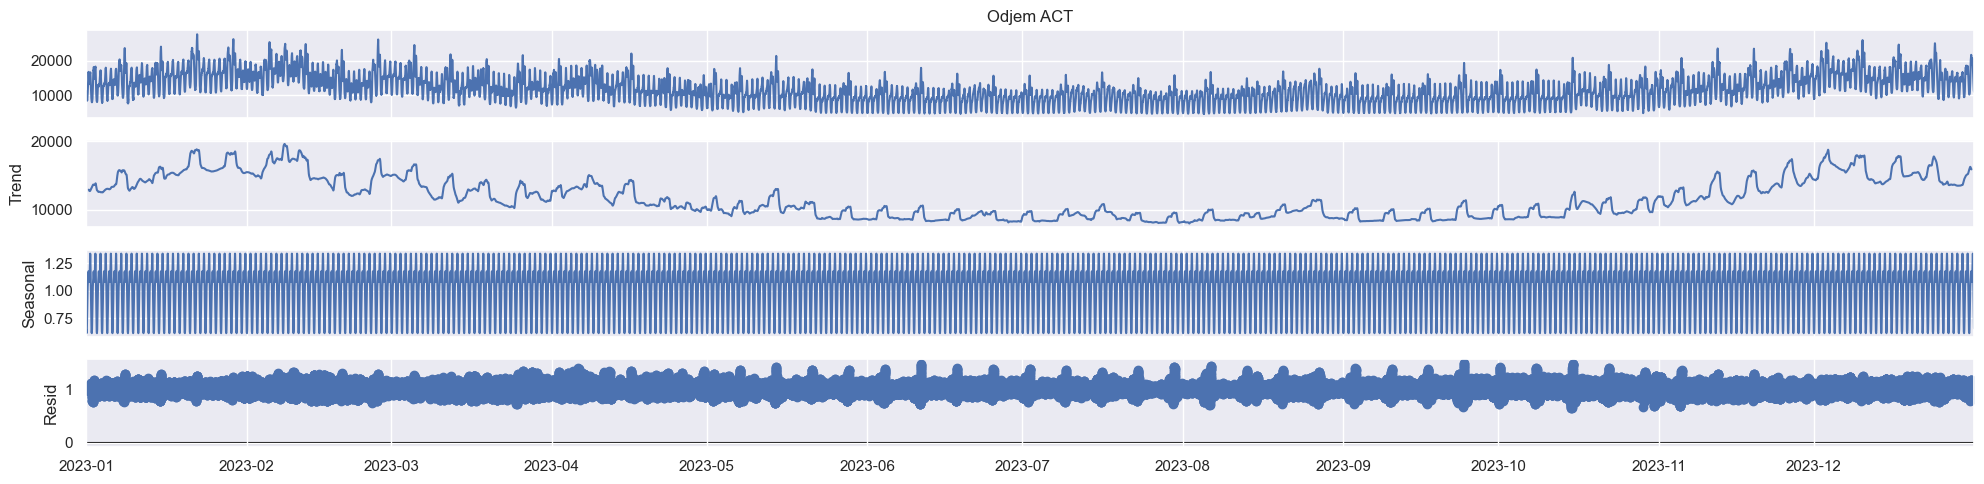

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

podatki_dec = podatki['Odjem ACT']
podatki_dec
decomp = seasonal_decompose(podatki.loc['2023', 'Odjem ACT'], model='multiplicative', period=96)
decomp.plot()

In [49]:
# opazke:
# - poraba je večja v zimskih mesecih
# - poraba se v času božičnih praznikov (konec decembra, začetek januarja) zmanjša
# - tisto kar je blizu nič predstavlja porabo tekom noči

<AxesSubplot: xlabel='DateTimeStartCET'>

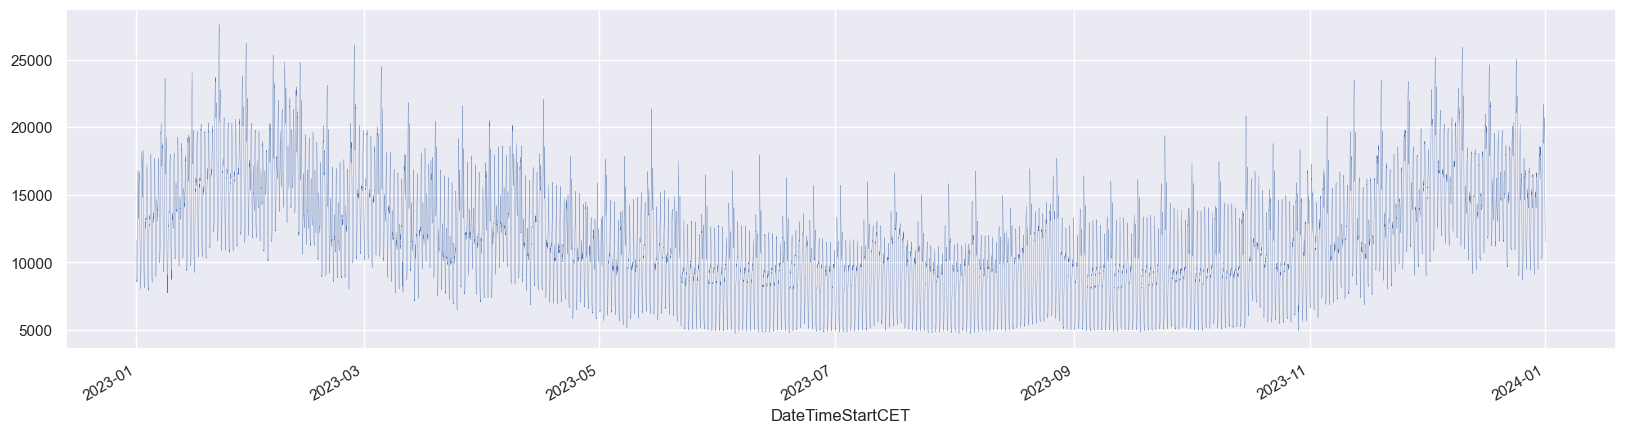

In [51]:
## odjem leta 2023:
podatki.loc['2023', 'Odjem ACT'].plot(linewidth=0.2)

In [43]:
# odjem za en teden
# podatki.loc['2022-03-01':'2022-03-07', 'Odjem ACT'].plot(marker='o', linestyle='-', linewidth=1, ms=3)

In [ ]:
## NAREDIMO ČASOVNO VRSTO STACIONARNO

# očitno je, da vrsta NI stacionarna

<AxesSubplot: xlabel='DateTimeStartUTC'>

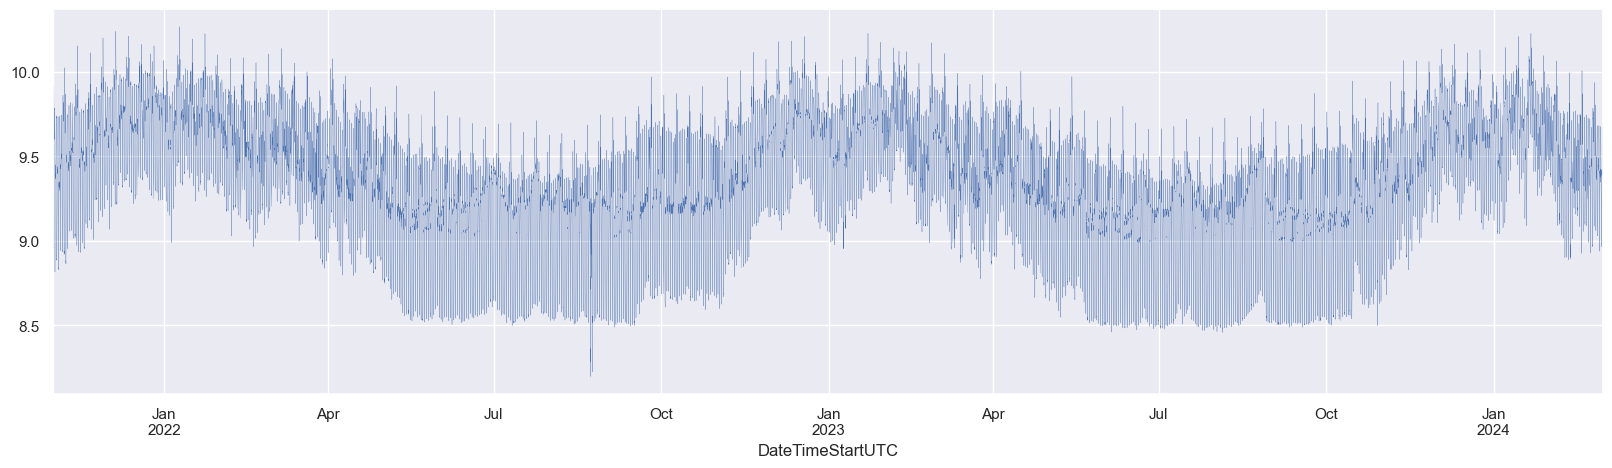

In [166]:
# Podatki so volatilni, zato najprej naredimo logaritemsko transformacijo (log(D_t)). Tako se vse malo bolj stabilizira 
podatki['Logaritem'] = np.log(podatki['Odjem ACT'])
podatki['Logaritem'].plot(linewidth=0.2)

Text(0.5, 1.0, 'Logaritem časovne vrste odjema, 2023')

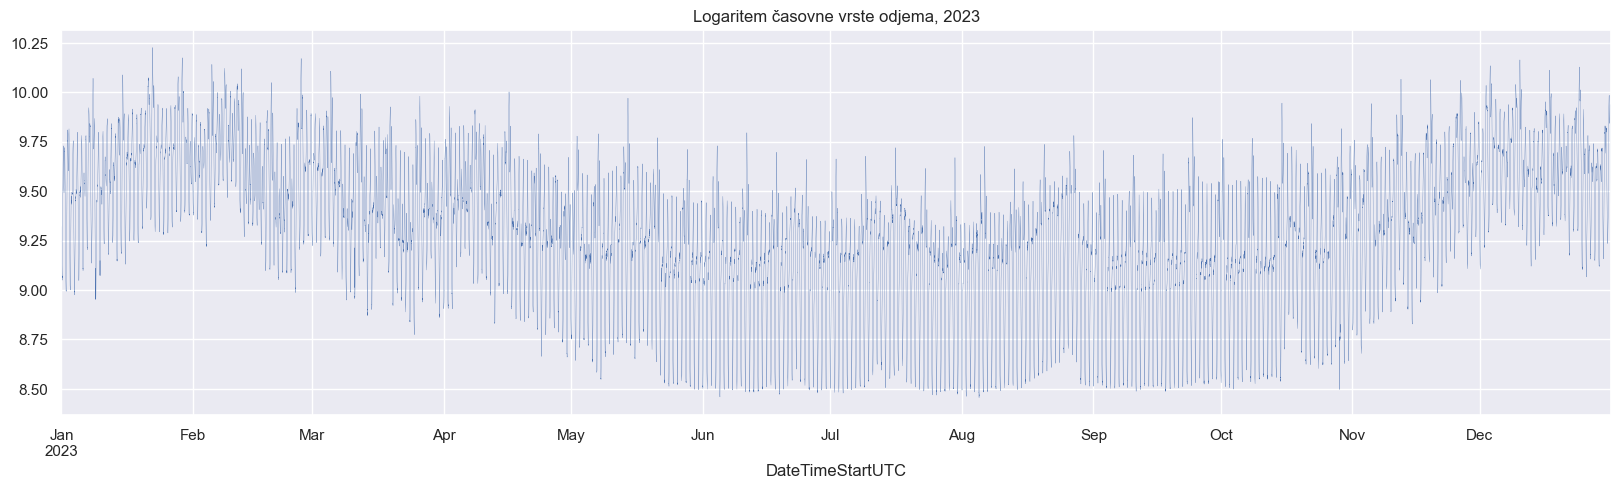

In [6]:
# zaradi velike količine podatkov, se bom osredotočala na leto 2023
podatki.loc['2023', 'Logaritem'].plot(linewidth=0.2) 
plt.title('Logaritem časovne vrste odjema, 2023')

In [58]:
# Log returns:
# podatki['log return'] = np.log(podatki['Odjem ACT']/podatki['Odjem ACT'].shift(-1))
# podatki['log return'].plot(linewidth=0.2)

In [164]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# The time series is considered stationary if the p-value is low (<0.05) 
#           and the Test Statistic is lower than the critical values at 1%, 5%, 10% levels of significance.

In [167]:
adf_test(podatki.loc['2023-03', 'Logaritem'].dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -1.182224e+01
p-value                        8.361425e-22
#Lags Used                     6.000000e+00
Number of Observations Used    2.969000e+03
Critical Value (1%)           -3.432554e+00
Critical Value (5%)           -2.862514e+00
Critical Value (10%)          -2.567288e+00
dtype: float64


Text(0.5, 1.0, 'ACF na logaritmu časovne vrste, 2023')

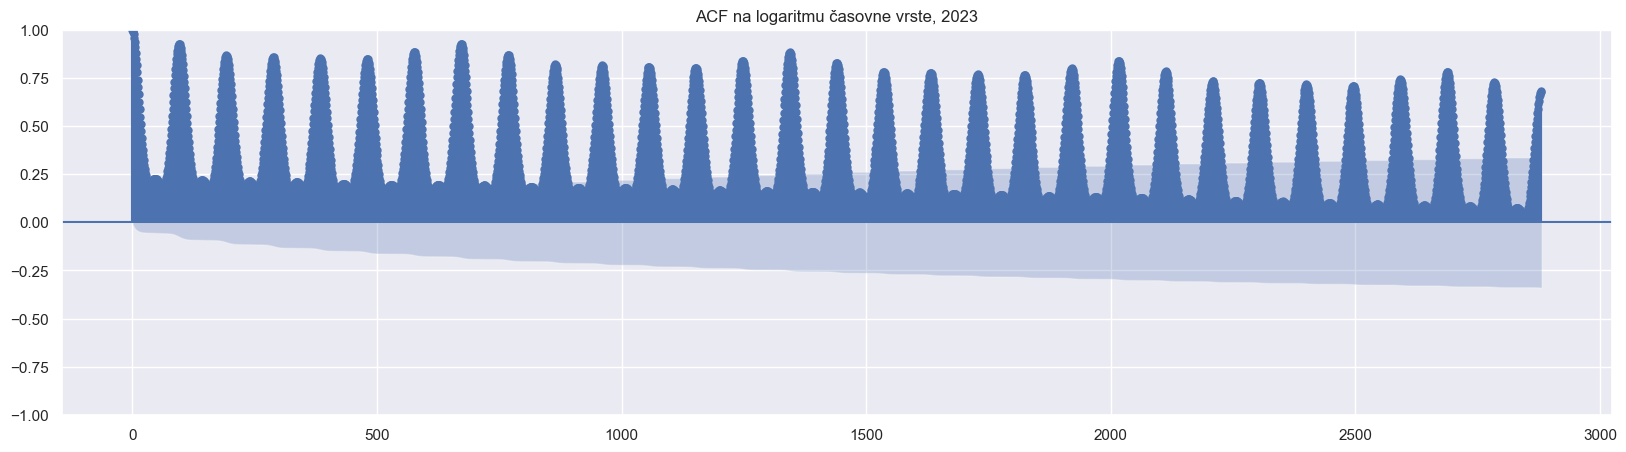

In [59]:
tsaplots.plot_acf(podatki.loc['2023', 'Logaritem'], lags=2880)
plt.ylim(-1,1)
plt.title('ACF na logaritmu časovne vrste, 2023')

# za lag sem vzela 2880, to je ravno 30 dni (96 podatkov na dan * 30 dni)

Text(0.5, 1.0, 'ACF na logaritmu časovne vrste, zoženo, 2023')

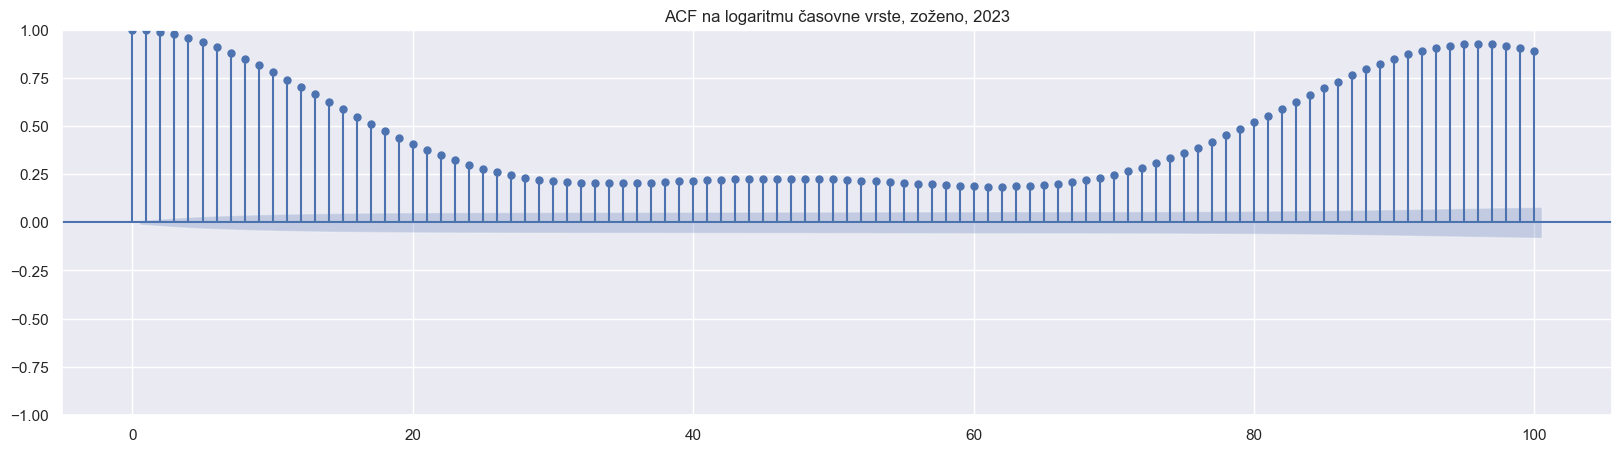

In [60]:
tsaplots.plot_acf(podatki.loc['2023', 'Logaritem'], lags=100)
plt.ylim(-1,1)
plt.title('ACF na logaritmu časovne vrste, zoženo, 2023') # -->sezonskost na vsake 96

In [94]:
# Iz ACF vidimo:
# - stacionarnosti NI
# - smiselno sezonsko komponento -> vse se ponavlja se na 1 dan (96 podatkov)

# da doseženo stacionarno poskusimo DIFERENCIRATI

Text(0.5, 1.0, 'Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

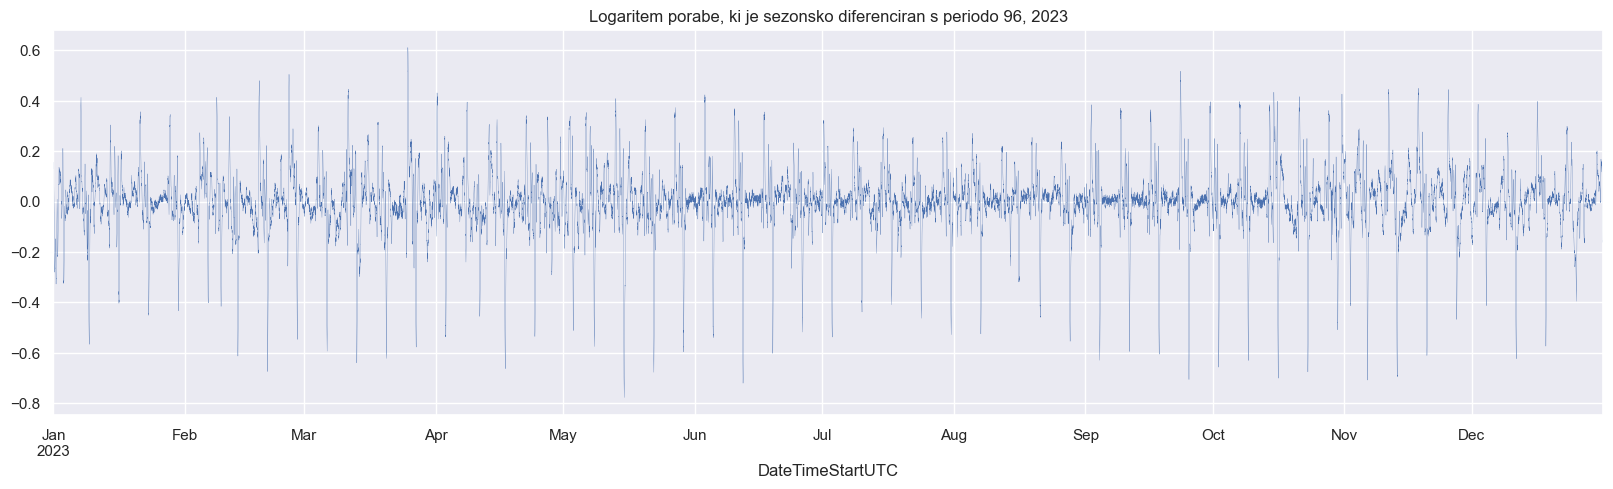

In [168]:
ts_diff = podatki['Logaritem'].diff(periods = 96)
ts_diff['2023'].plot(linewidth=0.2) 
plt.title('Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

In [ ]:
# opazimo, da je časovna vrsta kar precej bolj stacionarna. Preverimo še ACF

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju, 2023')

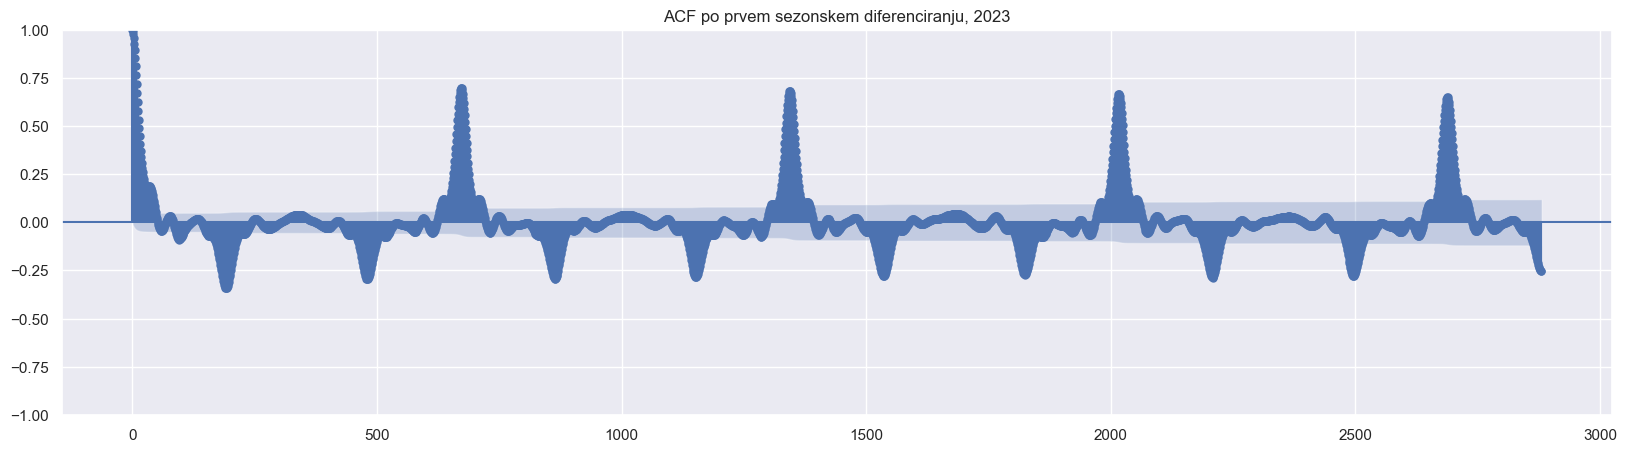

In [62]:
tsaplots.plot_acf(ts_diff['2023'], lags=2880)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju, zoženo, 2023')

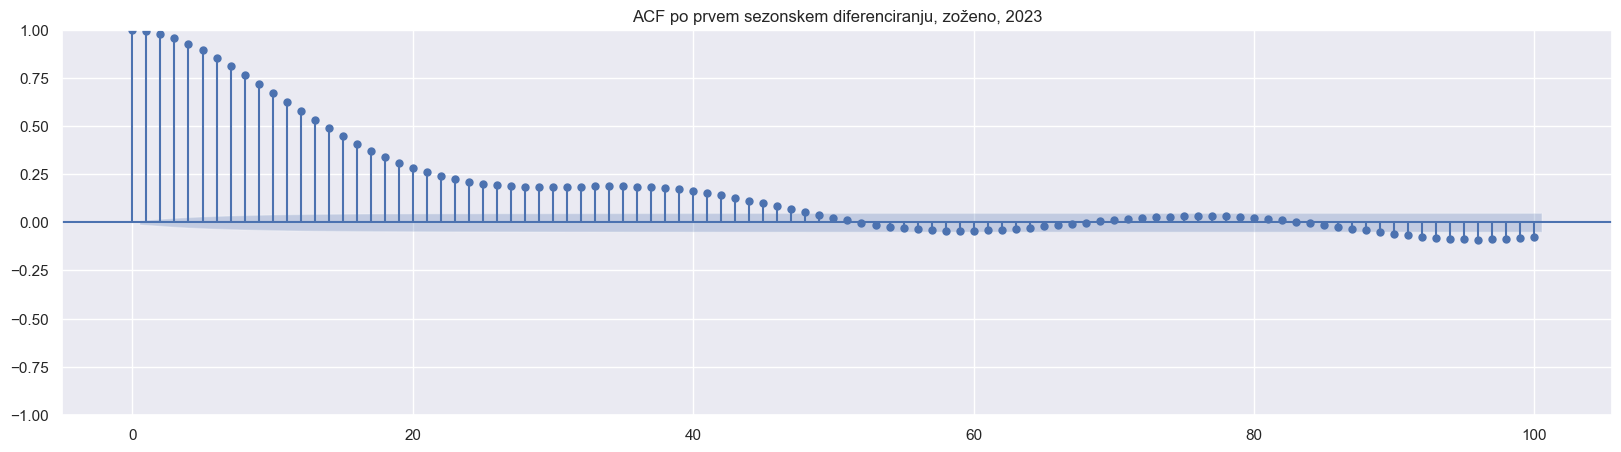

In [75]:
tsaplots.plot_acf(ts_diff['2023'], lags=100)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju, zoženo, 2023')

Text(0.5, 1.0, 'PACF po prvem sezonskem diferenciranju, zoženo, 2023')

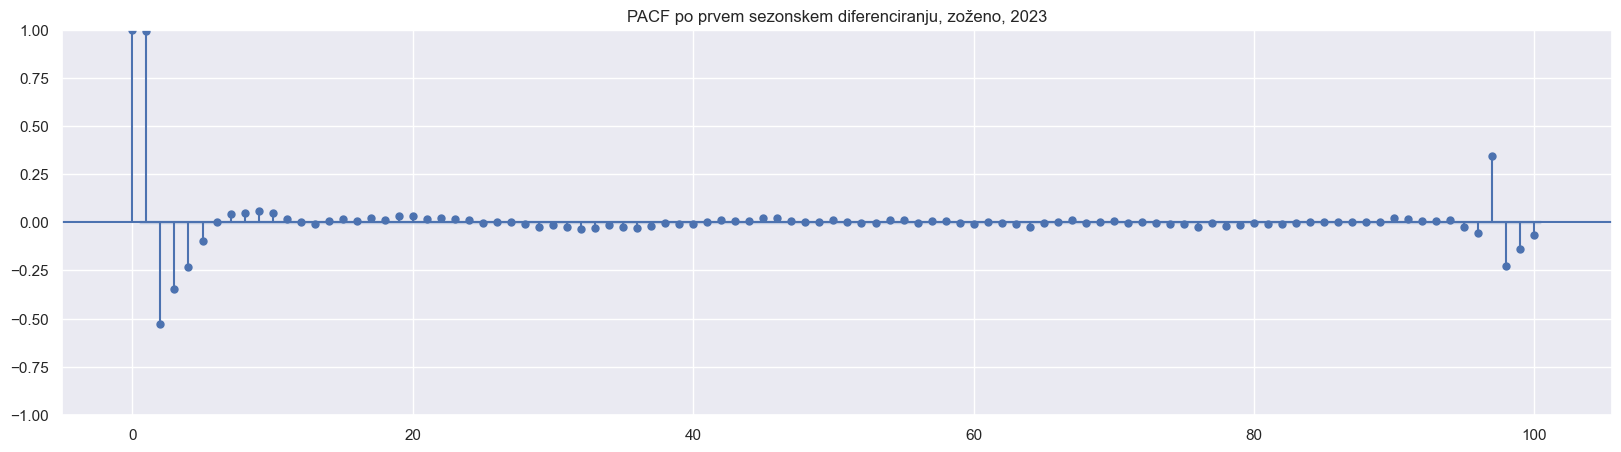

In [76]:
tsaplots.plot_pacf(ts_diff['2023'], lags=100)
plt.ylim(-1,1)
plt.title('PACF po prvem sezonskem diferenciranju, zoženo, 2023')

In [ ]:
# zgleda stacionarno, ampak diferencirajmo še enkrat

Text(0.5, 1.0, 'Po drugem diferenciranju, 2023')

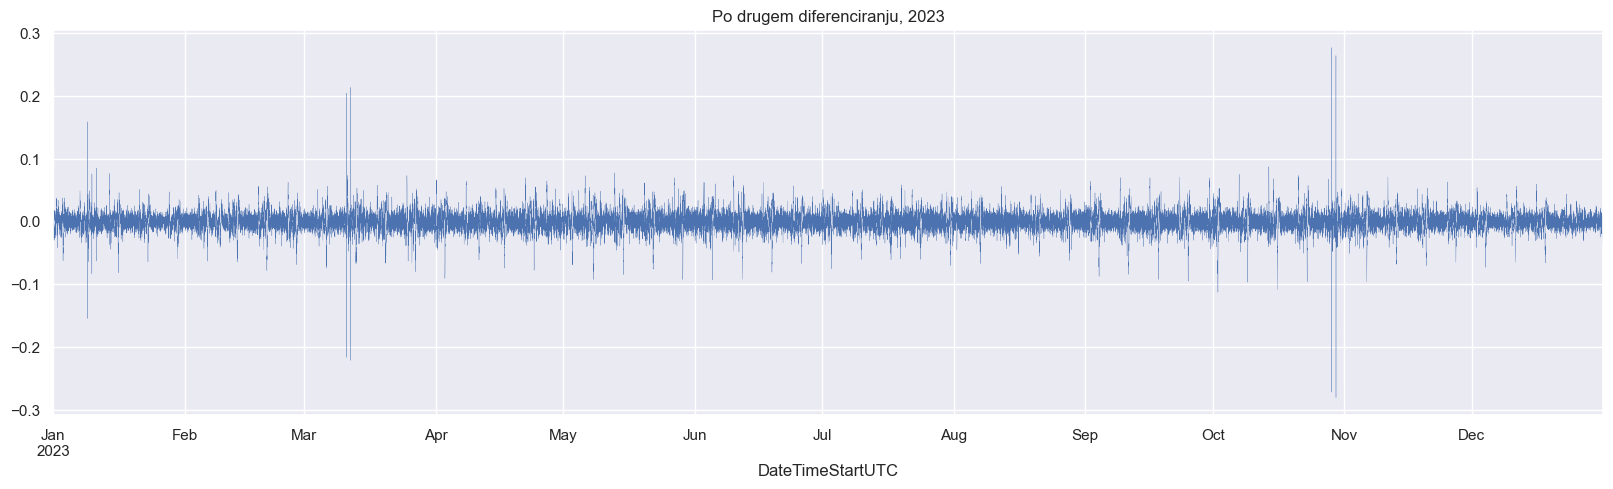

In [169]:
ts_diff2 = ts_diff.diff()
ts_diff2['2023'].plot(linewidth=0.2) 
plt.title('Po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, 2023')

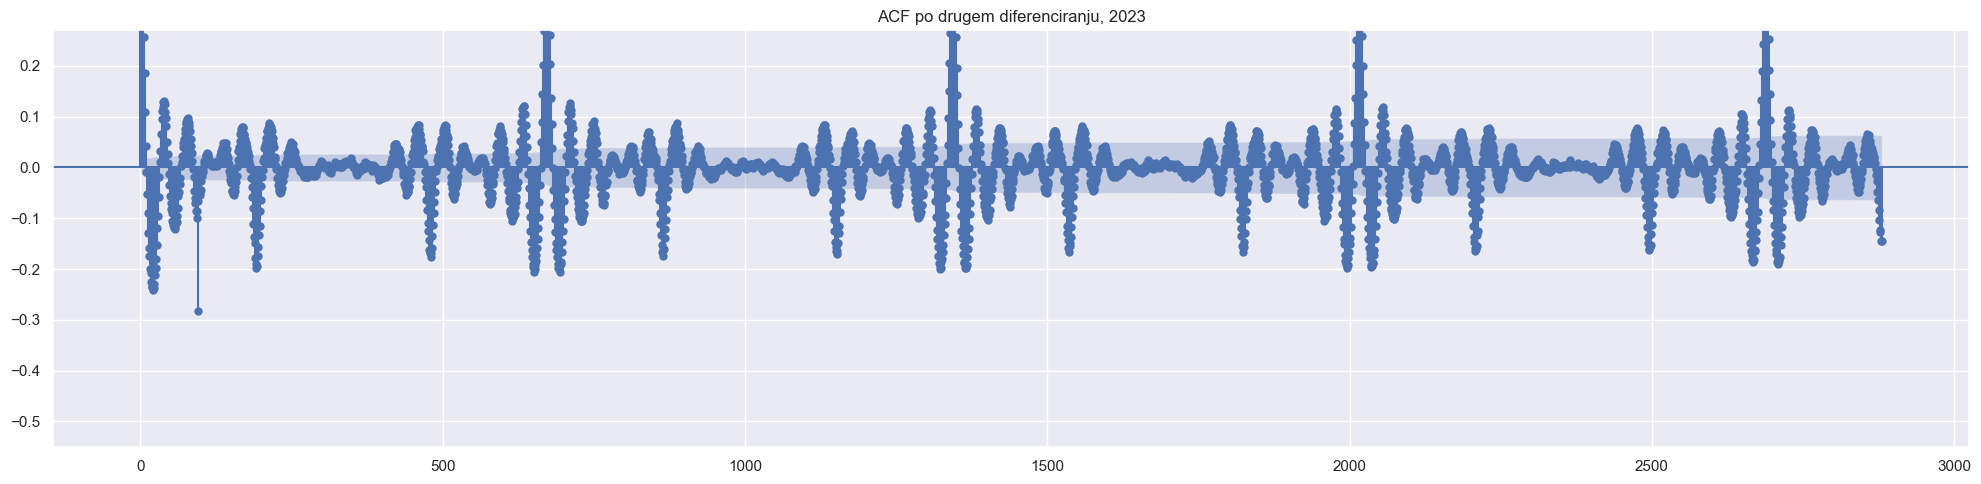

In [64]:
tsaplots.plot_acf(ts_diff2['2023'], lags=2880)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'Po tretjem diferenciranju, 2023')

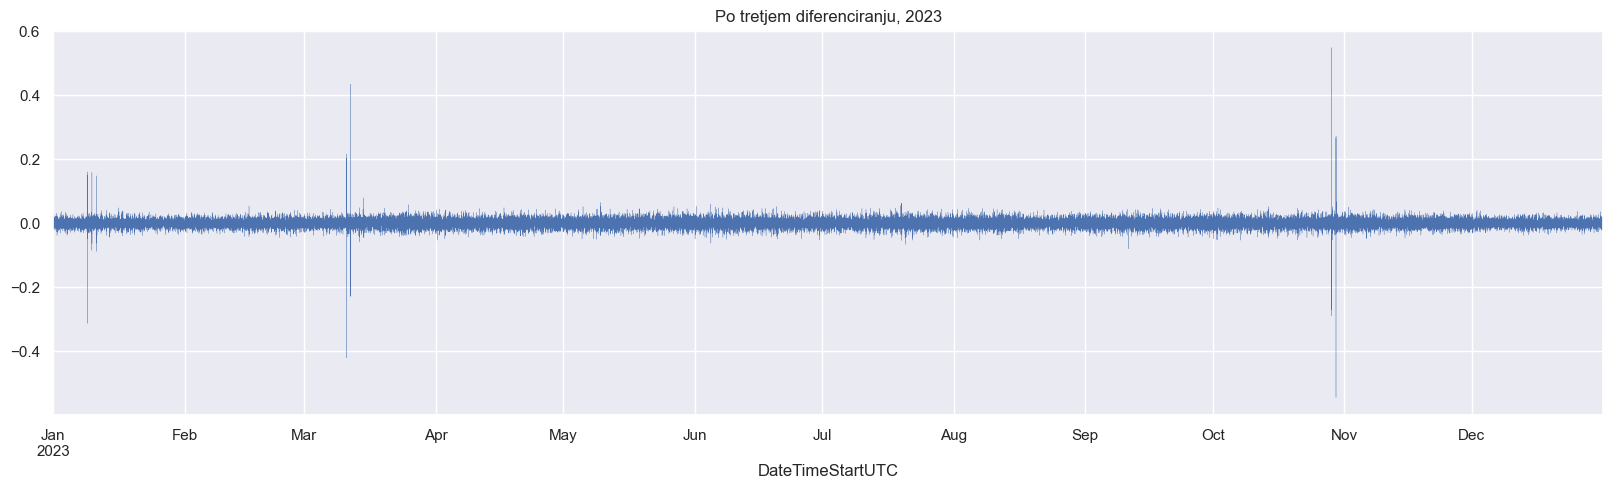

In [170]:
ts_diff3 = ts_diff2.diff()
ts_diff3['2023'].plot(linewidth=0.2) 
plt.title('Po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po tretjem diferenciranju, 2023')

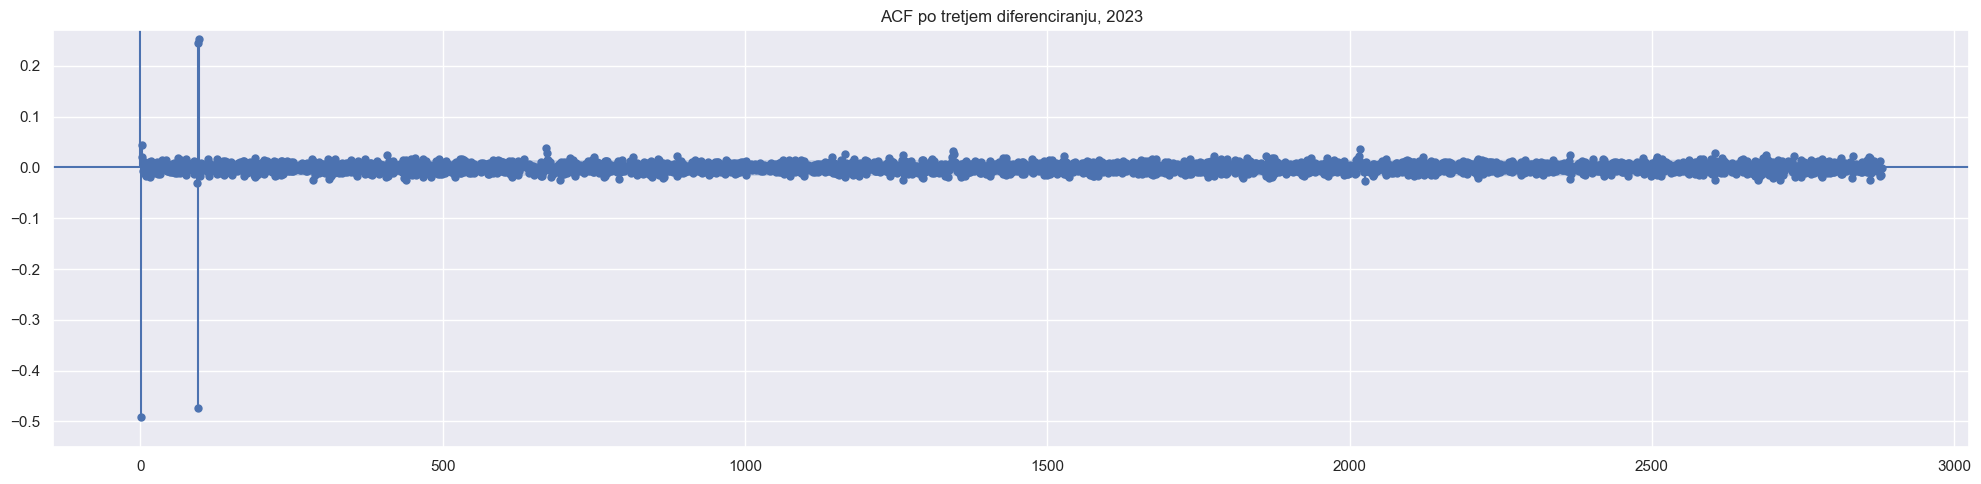

In [66]:
tsaplots.plot_acf(ts_diff3['2023'], lags=2880)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po tretjem diferenciranju, zožen lag, 2023')

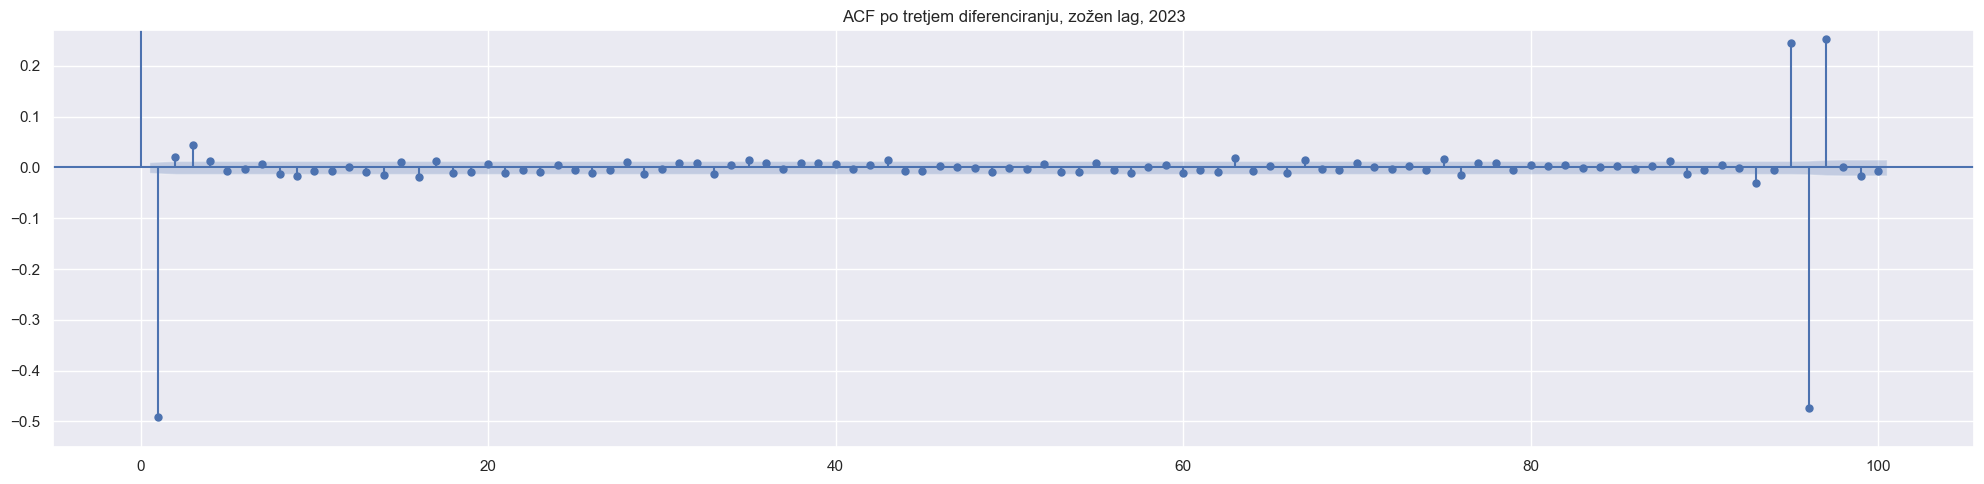

In [67]:
tsaplots.plot_acf(ts_diff3['2023'], lags=100)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po tretjem diferenciranju, zožen lag, 2023')

In [87]:
# sedaj zgleda še bolj stacionarno, torej je primerna za model ARMA

# iz ACF se visoko avtokorelacijo opazi pri: 1, 95, 96, 97

# RABIM FORMALNE TESTE?

import statsmodels.tsa.stattools as ts

def test_p_value(data):
        fuller_test = ts.adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')

test_p_value(ts_diff3.dropna())

P-value:  0.0
Reject null hypothesis, data is stationary


Text(0.5, 1.0, 'PACF po tretjem diferenciranju, 2023')

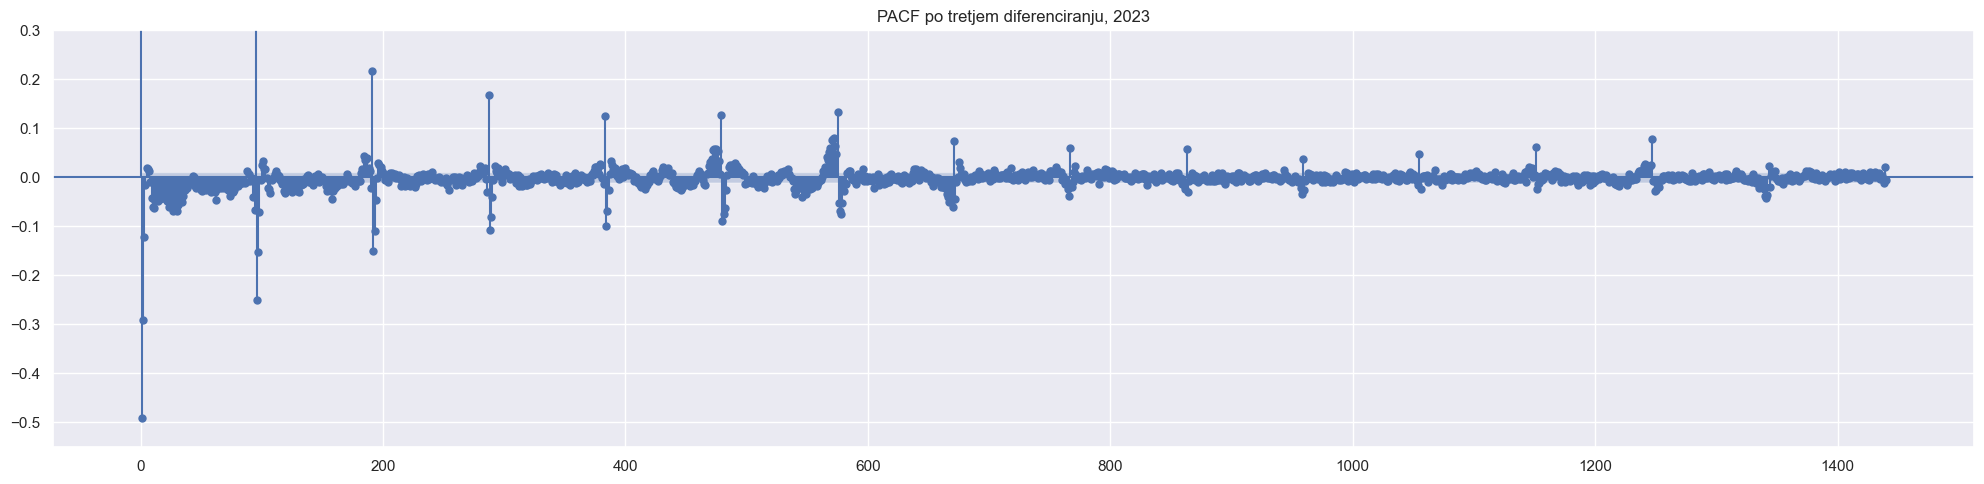

In [68]:
# zaradi izbire modelov si narišemo še PACF

tsaplots.plot_pacf(ts_diff3['2023'].values.squeeze(), lags=1440, method="ywm")
plt.ylim(-0.55,0.30)
plt.tight_layout()
plt.title('PACF po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'PACF po tretjem diferenciranju, zožen lag, 2023')

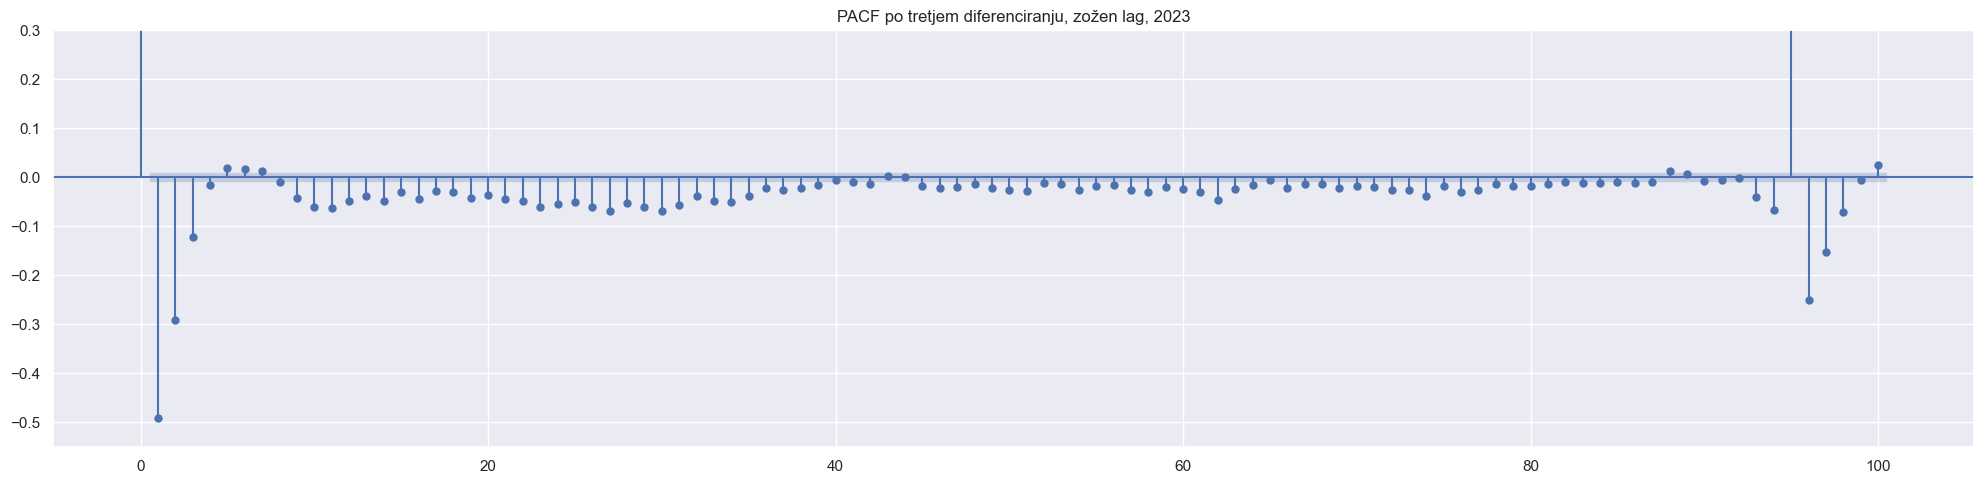

In [69]:
tsaplots.plot_pacf(ts_diff3['2023'].values.squeeze(), lags=100, method="ywm")
plt.ylim(-0.55,0.30)
plt.tight_layout()
plt.title('PACF po tretjem diferenciranju, zožen lag, 2023')

In [ ]:
# visoka korelacije je pri: 1, 2, 3 _____ nato se ponovi pri 95, 191, ... torej se ponovi na 96

# PACF -> AR(p)
# ACF -> MA(q)


# ACF in PACF povesta katere log bi bilo potrebno vključiti
# Zagotovo bomo vključili prvih nekaj meritev/ur, ker imajo večji vpliv
# Koliko dodatnih log-ov bomo še vključili, pa se bomo odločili s pomočjo kriterija AIC

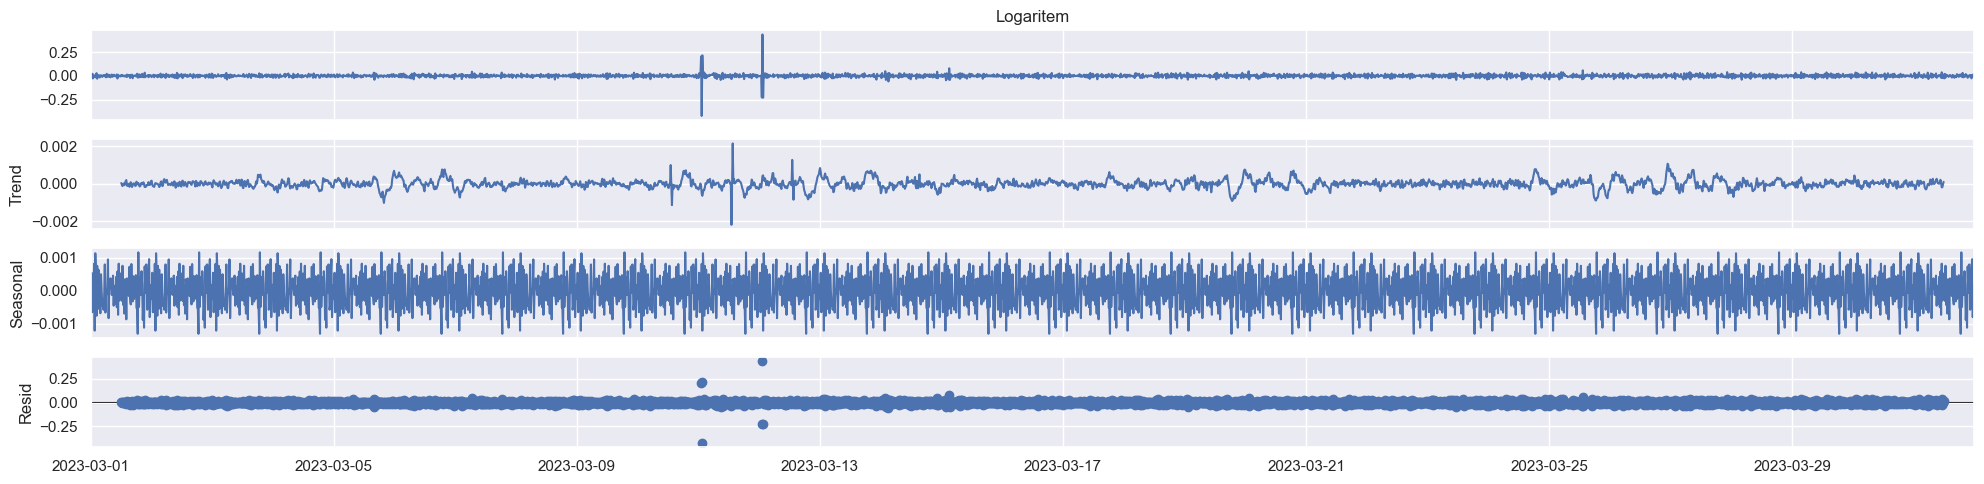

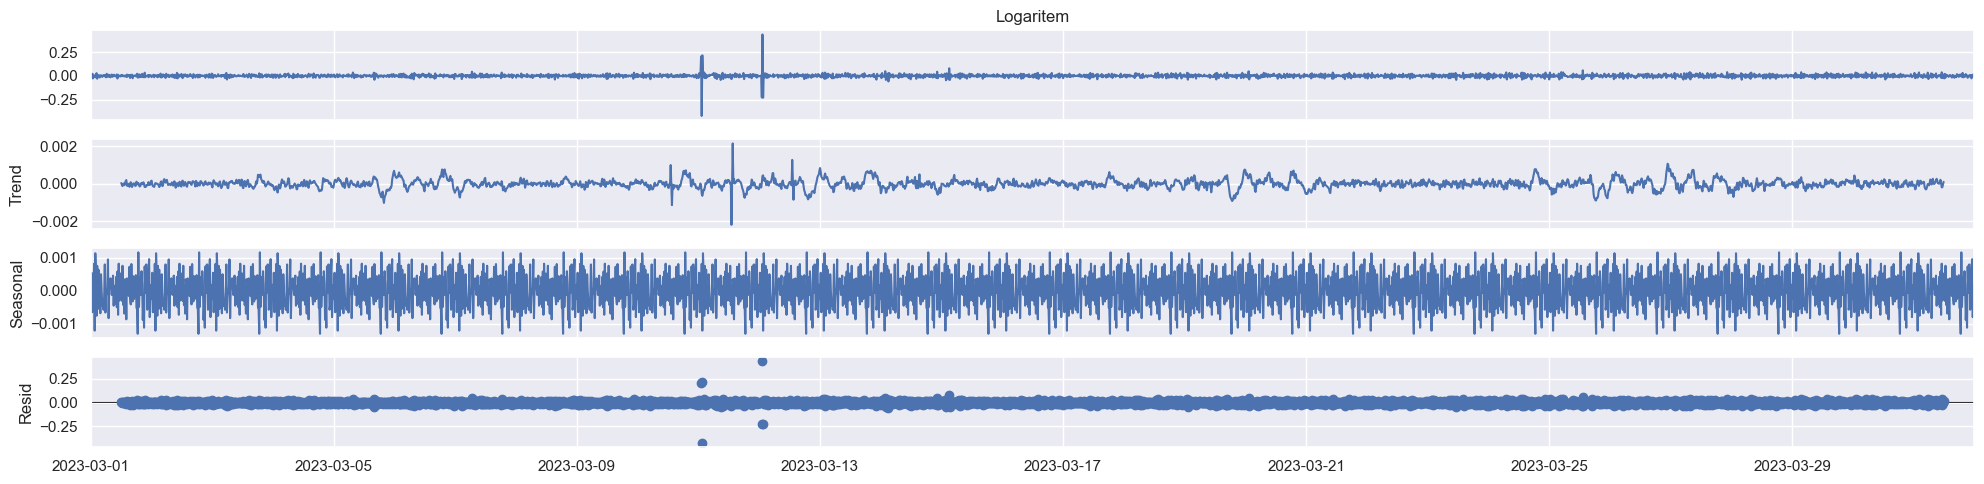

In [70]:
seasonal_decompose(ts_diff3['2023-03'].dropna(), model='additive', period=96).plot()

In [229]:
## MODELI

# da bo šlo bolj hitro se zaenkrat omejimo na samo na dva meseca:
# train data:
train_data = ts_diff3['2022-11':'2023-05']
train_data_1 = ts_diff['2022-11':'2023-05']
train_data_OG = podatki.loc['2022-11':'2023-05', 'Logaritem']

temp_data = podatki.loc['2022-11':'2023-05', 'Temperatura FC']
temp_data_1 = podatki.loc['2022-11':'2023-05', 'Temperatura FC']

# test data:
test_data = ts_diff3['2023-06-01']
test_data_1 = ts_diff['2023-06-01']
test_data_OG = podatki.loc['2023-06-01', 'Logaritem']

test_temp_data = podatki.loc['2023-06-01', 'Temperatura FC']
test_temp_data_1 = podatki.loc['2023-06-01', 'Temperatura FC']

In [ ]:
# uporabljam SARIMA ker imam sezonsko konponento

# !! PRIMERJAVA MED SARIMA in ARIMA !!

In [104]:
from pmdarima import auto_arima

ARIMA_model = auto_arima(ts_diff.dropna(), 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      tr=5, max_q=5, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=2,
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
ARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-462505.021, Time=33.84 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-429338.736, Time=6.26 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-451652.183, Time=9.20 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-461602.915, Time=15.66 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-429340.736, Time=2.95 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-463033.232, Time=6.75 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-460799.108, Time=10.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-463114.466, Time=29.86 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-462924.121, Time=17.58 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-463145.363, Time=115.16 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-463173.171, Time=16.77 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-463171.228, Time=23.18 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-463171.096, Time=76.90 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-463175.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                81600
Model:               SARIMAX(4, 2, 0)   Log Likelihood              231592.586
Date:                Thu, 16 May 2024   AIC                        -463175.171
Time:                        13:45:32   BIC                        -463128.623
Sample:                    11-01-2021   HQIC                       -463160.915
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7096      0.001   -919.567      0.000      -0.711      -0.708
ar.L2         -0.4535      0.001   -353.501      0.000      -0.456      -0.451
ar.L3         -0.1992      0.001   -142.428      0.000      -0.202      -0.197
ar.L4         -0.0554      0.001    -48.450      0.000      -0.058      -0.053
sigma2         0.0002   2.05e-07    979.857      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          13305572.59
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

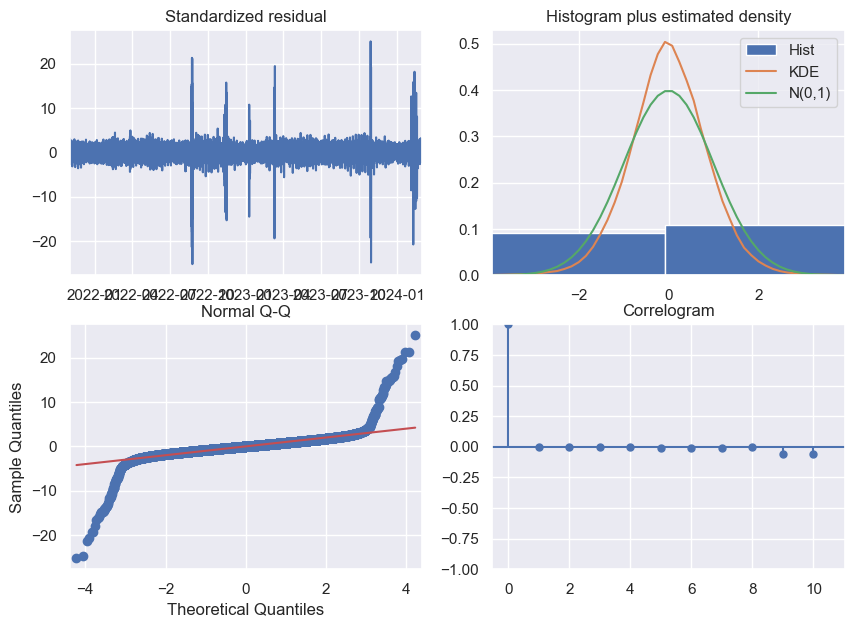

In [198]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

In [228]:
model = sm.tsa.statespace.SARIMAX(train_data_OG, order=(1,2,1), seasonal_order=(1,1,0,96), simple_differencing=False)
results = model.fit()
results.summary()

KeyboardInterrupt: 

In [226]:
final_predict = pd.DataFrame(results.predict(start=len(train_data_OG), end=(len(train_data_OG) + len(test_data_OG))))
final_predict.columns=['pred']
# final_predict

fully_final = pd.concat((final_predict, test_data_OG), axis = 1)
fully_final

pred  Logaritem
2023-06-01 00:00:00  8.554228   8.566876
2023-06-01 00:15:00  8.523297   8.533867
2023-06-01 00:30:00  8.492334   8.519648
2023-06-01 00:45:00  8.461375   8.510299
2023-06-01 01:00:00  8.430415   8.516243
...                       ...        ...
2023-06-01 23:00:00  5.705958   8.682935
2023-06-01 23:15:00  5.674998   8.640460
2023-06-01 23:30:00  5.644038   8.607860
2023-06-01 23:45:00  5.613079   8.584555
2023-06-02 00:00:00  5.582119        NaN

[97 rows x 2 columns]

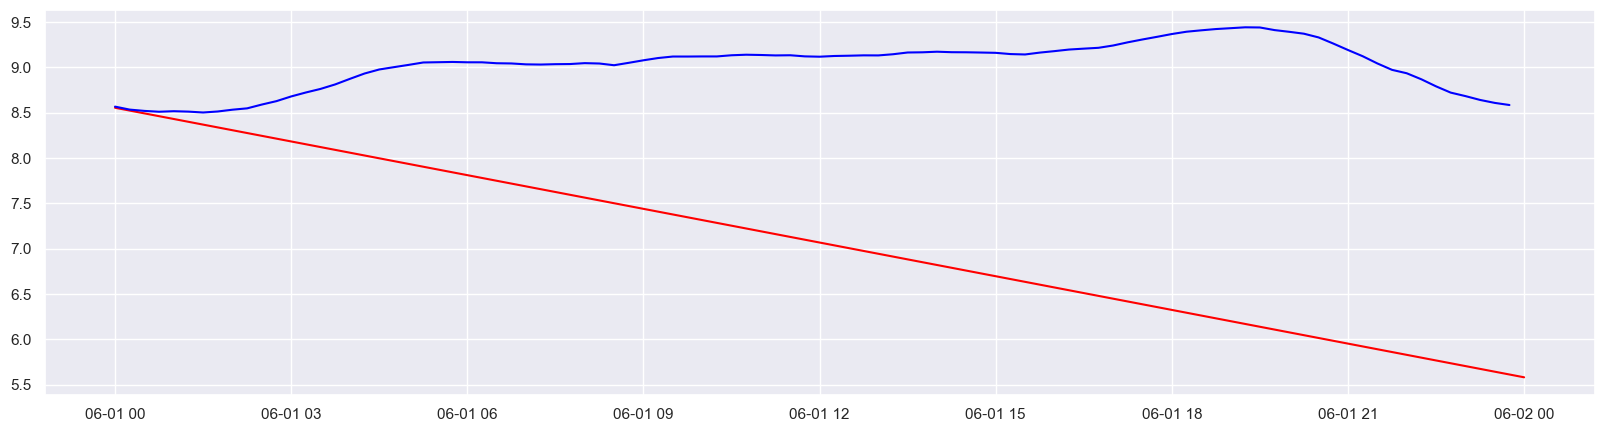

In [227]:
plt.plot(fully_final.index, fully_final['pred'], color = 'red')
plt.plot(fully_final.index, fully_final['Logaritem'], color = 'blue')

In [201]:
residuals = results.resid

In [230]:
model_1 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(1,2,1), seasonal_order=(1,1,1,96))
results_1 = model_1.fit()
# results_1.summary()

KeyboardInterrupt: 

In [19]:
model_2 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(1,2,1), seasonal_order=(1,1,0,96))
results_2 = model_2.fit()

In [158]:
# model_3 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(3,2,1), seasonal_order=(1,1,0,96))
# results_3 = model_3.fit()

model_3 = sm.tsa.statespace.SARIMAX(train_data, order=(3,0,1), seasonal_order=(1,0,0,96))
results_3 = model_3.fit()

KeyboardInterrupt: 

In [42]:
model_4 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(3,2,1), seasonal_order=(2,1,1,96))
results_4 = model_4.fit()

In [43]:
model_5 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(3,2,1), seasonal_order=(1,1,1,96))
results_5 = model_5.fit()

In [16]:
model_6 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,2,1), seasonal_order=(1,1,1,96))
results_6 = model_6.fit()

In [80]:
model_7 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,2,2), seasonal_order=(0,1,1,96))
results_7 = model_7.fit()

In [22]:

pd.DataFrame([
    ['ARIMA(1,2,1)', 1, 2, 1, 0, 0, 0, 0, sm.tsa.statespace.SARIMAX(train_data_OG, order=(1,2,1)).fit().aic],
    ['ARIMA(3,2,1)', 3, 2, 1, 0, 0, 0, 0, sm.tsa.statespace.SARIMAX(train_data_OG, order=(2,2,1)).fit().aic],
    ['SARIMA(1,2,1)(1,1,0)[96]', 1, 2, 1, 1, 1, 0, 96, results_2.aic], 
    ['SARIMA(1,2,1)(1,1,1)[96]', 1, 2, 1, 1, 1, 1, 96, results_1.aic],
    ['SARIMA(3,2,1)(1,1,0)[96]', 3, 2, 1, 1, 1, 0, 96, results_3.aic],
    ['SARIMA(0,2,1)(1,1,1)[96]', 0, 2, 1, 1, 1, 1, 96, results_6.aic]
],
columns=('Model', 'p', 'd', 'q', 'P', 'D', 'Q', 'S', 'AIC'))

5 4


Model  p  d  q  P  D  Q   S          AIC
0              ARIMA(1,2,1)  1  2  1  0  0  0   0  8638.425335
1              ARIMA(3,2,1)  3  2  1  0  0  0   0  8638.217304
2  SARIMA(1,2,1)(1,1,0)[96]  1  2  1  1  1  0  96  7487.250323
3  SARIMA(1,2,1)(1,1,1)[96]  1  2  1  1  1  1  96  7395.041474
4  SARIMA(3,2,1)(1,1,0)[96]  3  2  1  1  1  0  96  7488.873575
5  SARIMA(0,2,1)(1,1,1)[96]  0  2  1  1  1  1  96  7393.196604

<AxesSubplot: xlabel='DateTimeStartUTC'>

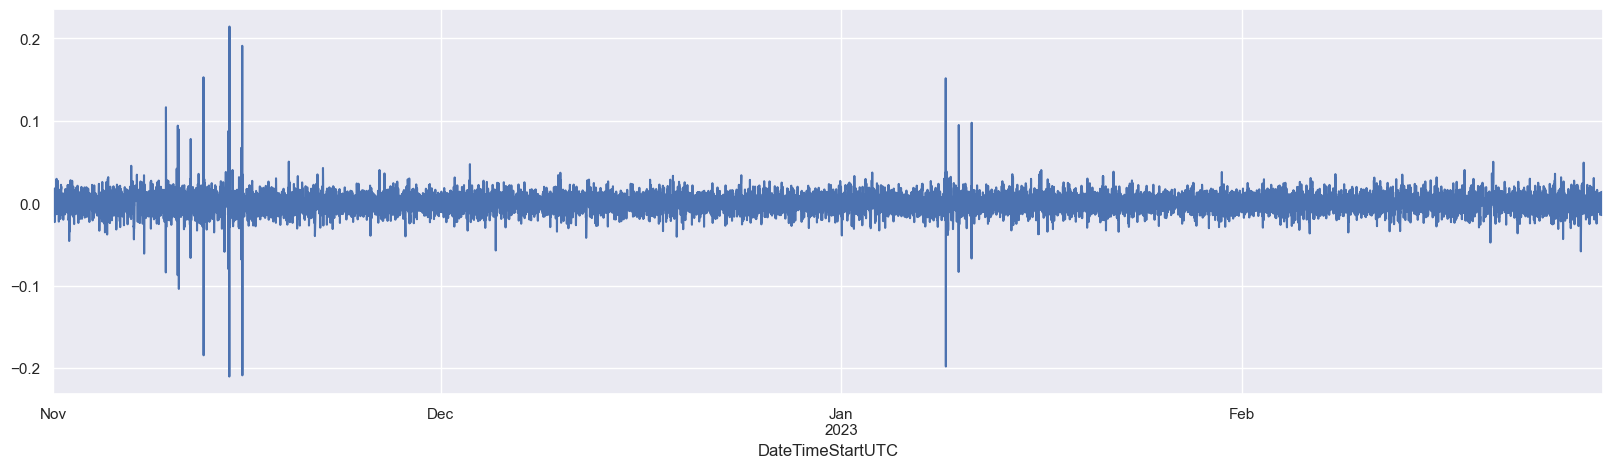

In [181]:
results.resid.plot()

Text(0.5, 1.0, 'ACF za SARIMAX')

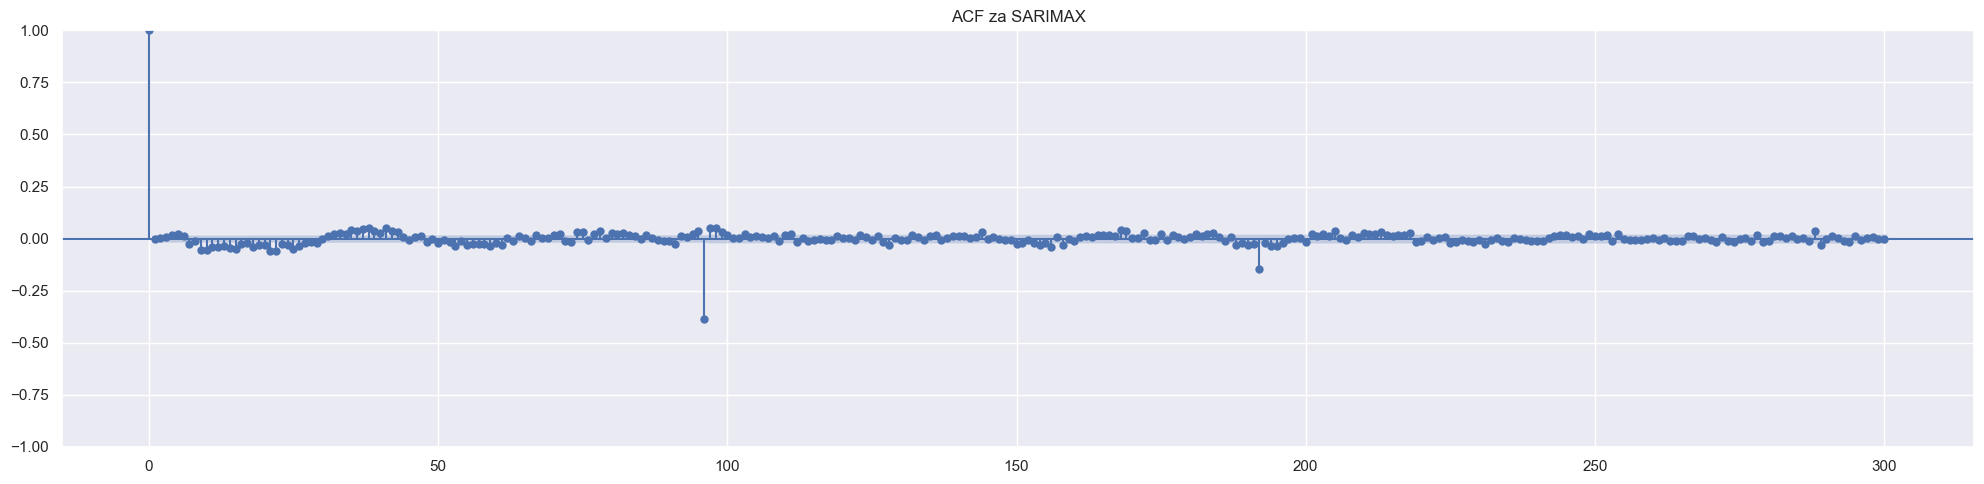

In [182]:
tsaplots.plot_acf(results.resid.values.squeeze(), lags=300)
plt.ylim(-1,1)
plt.tight_layout()
plt.title('ACF za SARIMAX')

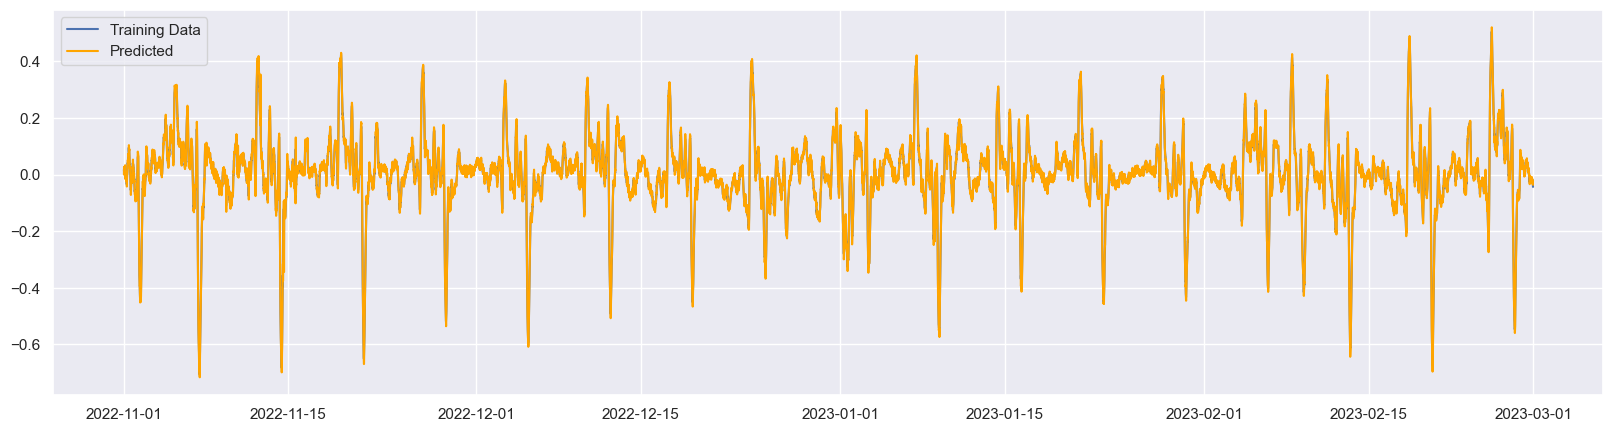

In [184]:
# df['prediction'] = 
results.predict()
# >>> df[['Production','prediction']].plot(figsize=(12,8))

plt.plot(train_data_1, label='Training Data')
plt.plot(results.predict(), label='Predicted', color='orange')
plt.legend()

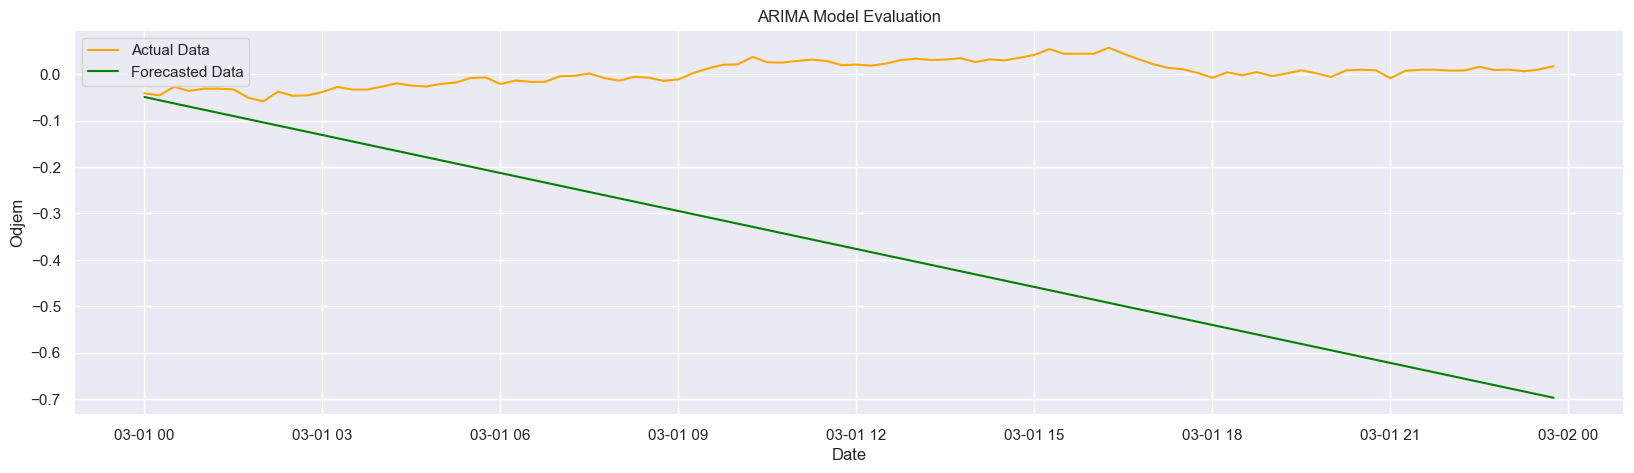

In [196]:
# forecast = results.forecast(steps = 96)
# # forecast

# # plt.plot(train_data_1, label='Training Data')
# # plt.plot(test_data_1, label='Actual Data', color='orange')
# # plt.plot(forecast, label='Forecasted Data', color='green')
# # plt.title('ARIMA Model Evaluation')
# # plt.xlabel('Date')
# # plt.ylabel('Odjem')
# # plt.legend()
# # plt.show()


# model = SARIMAX(train_data,order=(2,0,0),enforce_invertibility=False)
# results = model.fit()
# results.summary()


# FORECAST on the test dataset
test_forecast = results.forecast(steps=96)
# test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data_1.index)


# narišemo
# plt.plot(train_data_1, label='Training Data')
plt.plot(test_data_1, label='Actual Data', color='orange')
plt.plot(test_forecast, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()

In [ ]:



## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================




In [82]:
## MULTIVARIATE MODEL

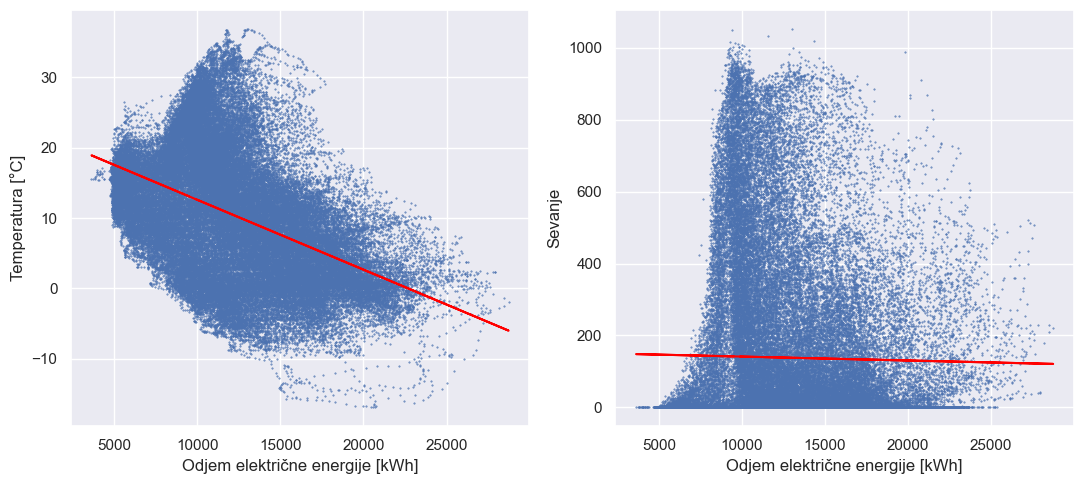

In [27]:
# Povezava med temperaturo in odjemom:

# temperatura
X = np.array(podatki["Odjem ACT"]).reshape(-1, 1)
y = np.array(podatki["Temperatura ACT"])
reg = LinearRegression().fit(X, y)
podatki['predicted'] = reg.predict(X)

# sevanje
X_S = np.array(podatki["Odjem ACT"]).reshape(-1, 1)
y_S = np.array(podatki["Sevanje ACT"])
reg = LinearRegression().fit(X_S, y_S)
podatki['predicted_S'] = reg.predict(X_S)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11, 5))

ax1 = plt.subplot(1, 2, 1)
podatki.plot.scatter(x = "Odjem ACT", y = "Temperatura ACT", s = 0.2, ax = ax1, legend=False)
podatki.plot.line(x = "Odjem ACT", y = 'predicted', ax = ax1, color="red", legend=False)
plt.xlabel('Odjem električne energije [kWh]')
plt.ylabel('Temperatura [°C]')

ax1 = plt.subplot(1, 2, 2)
podatki.plot.scatter(x = "Odjem ACT", y = "Sevanje ACT", s = 0.2, ax = ax2, legend=False)
podatki.plot.line(x = "Odjem ACT", y = 'predicted_S', ax = ax2, color="red", legend=False)
plt.xlabel('Odjem električne energije [kWh]')
plt.ylabel('Sevanje')

plt.tight_layout()


In [ ]:
# opazna je povezava --> ?? FORMALNO JE TREBA ŠE PREVERITI KORELIRANOST in te zadevice ??

# sevanja verjetno ne bom uporabljala ??

In [38]:
model_multi = sm.tsa.statespace.SARIMAX(train_data_1, order=(3,2,1), exog=temp_data_1)
results_multi = model_multi.fit()
results_multi.summary()


# model_multi = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,2,1), seasonal_order=(1,1,1,96), exog=temp_data)
# results_multi = model_multi.fit()
# results_multi.summary()

# fit1= SARIMAX(Train["Monthly_Rate"], order=(1, 0, 1),seasonal_order=(1,1,0,12), exog = sar["Bank Rate Lagged"], 
#              trend='ct', simple_differencing=False,enforce_stationarity=False).fit()
# print(fit1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Logaritem   No. Observations:                 2688
Model:               SARIMAX(3, 2, 1)   Log Likelihood                8345.314
Date:                Thu, 16 May 2024   AIC                         -16678.628
Time:                        11:52:34   BIC                         -16643.253
Sample:                    02-01-2023   HQIC                        -16665.832
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Temperatura FC     0.0005      0.002      0.196      0.845      -0.004       0.005
ar.L1             -0.2468      0.151     -1.636      0.102      -0.542       0.049
ar.L2             -0.1453      0.086     -1.681      0.093      -0.315       0.024
ar.L3             -0.0173      0.049     -0.353      0.724      -0.114       0.079
ma.L1             -0.3323      0.148     -2.249      0.024      -0.622      -0.043
sigma2             0.0001   2.89e-06     40.535      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                46.66
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

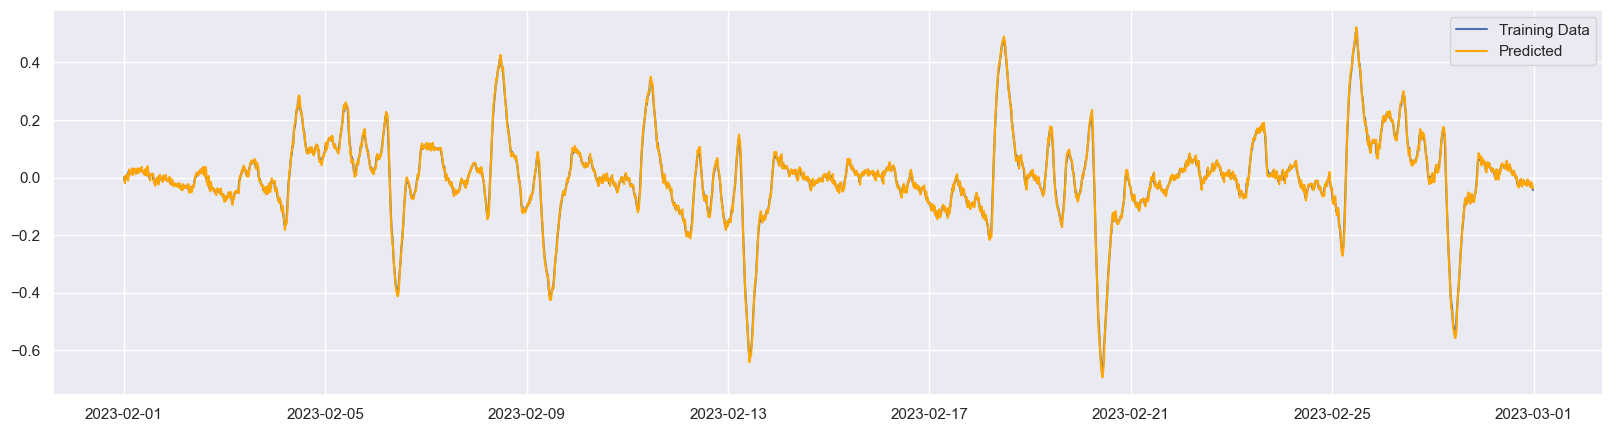

In [39]:
plt.plot(train_data_1, label='Training Data')
plt.plot(results_multi.predict(exog=temp_data_1), label='Predicted', color='orange')
plt.legend()

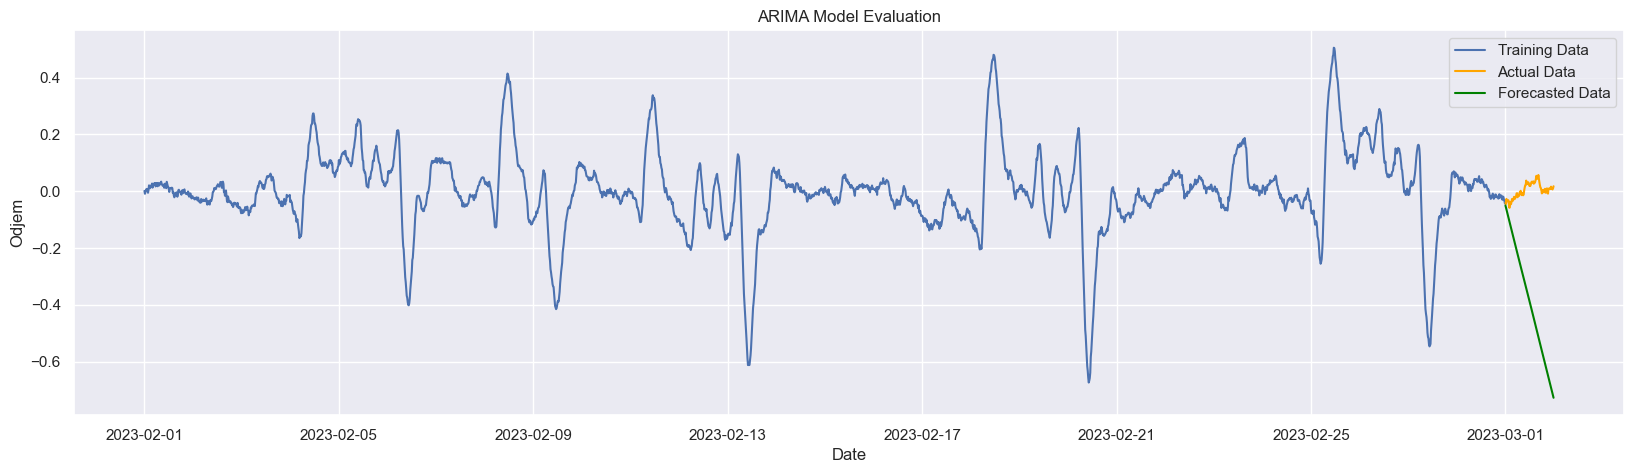

In [41]:
# FORECAST on the test dataset
test_forecast = results_multi.get_forecast(steps=96, exog=test_temp_data_1)
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data_1.index)

# narišemo
plt.plot(train_data_1, label='Training Data')
plt.plot(test_data_1, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()